# Sprintup Project - 3. Feature Selection

In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from collections import Counter

In [2]:
%%capture
%run "./01_data_preprocessing.ipynb"

So we will use multiple feature selection methods to identify the most important features in our dataset.
These methods include XGBoost, Recursive Feature Elimination (RFE), and Chi-Square Test.
We will then compare the results from these methods to identify a set of primary features that are consistently important across different techniques.

let's get started with XGBoost Feature Importance

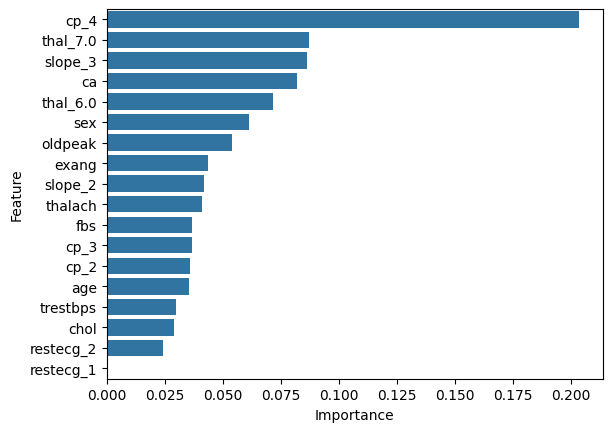

Top 8 XGBOOST features: ['cp_4', 'thal_7.0', 'slope_3', 'ca', 'thal_6.0', 'sex', 'oldpeak', 'exang']


In [3]:
# we first train a xgboost model and then extract feature importances   
xgb = XGBClassifier()
xgb.fit(X_encoded_scaled, y)
xgb_feature_importances = xgb.feature_importances_
df_xgb_features = pd.DataFrame({'Feature': X_encoded_scaled.columns, 'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)
# Plot importance
sns.barplot(x=df_xgb_features['Importance'], y=df_xgb_features['Feature'], orient='h')
plt.show()
#visualizing the top 8 features
top_8_xgboost_features = df_xgb_features['Feature'].head(8).tolist() 
print('Top 8 XGBOOST features:' ,top_8_xgboost_features)


### After XGBoost, let's apply the recursive feature elimination (RFE) method

In [4]:

# We want to find the best 8 features 
rfe = RFE(n_features_to_select=8,estimator=XGBClassifier())

# first we fit the RFE model
rfe.fit(X_encoded_scaled, y)

# then we get the selected features 
rfe_features = X_encoded_scaled.columns[rfe.support_].tolist()
print(" Top 8 RFE Features:", rfe_features)

# Create a DataFrame to display feature rankings
feature_ranks = pd.DataFrame({'Feature': X_encoded_scaled.columns,'RFE_Rank': rfe.ranking_}).sort_values('RFE_Rank')

#Displaying the feature rankings(lower is better)
print(" Feature Rankings:")
print(feature_ranks)
print('AS we can see from the above table, the top 8 features have rank 1')

 Top 8 RFE Features: ['sex', 'fbs', 'oldpeak', 'ca', 'cp_4', 'slope_2', 'slope_3', 'thal_7.0']
 Feature Rankings:
      Feature  RFE_Rank
1         sex         1
4         fbs         1
7     oldpeak         1
8          ca         1
15    slope_3         1
14    slope_2         1
11       cp_4         1
17   thal_7.0         1
16   thal_6.0         2
5     thalach         3
6       exang         4
0         age         5
2    trestbps         6
9        cp_2         7
3        chol         8
10       cp_3         9
13  restecg_2        10
12  restecg_1        11
AS we can see from the above table, the top 8 features have rank 1


### Now let's apply the Chi-Square Test ###

In [5]:
# Chi-Square works best with categorical data and non-negative values
# Since we scaled our data, we need to make sure it's non-negative
scaler_minmax = MinMaxScaler()
X_non_negative = scaler_minmax.fit_transform(X_encoded_scaled)

We applied MinMax scaling to transform features into the [0,1] range, ensuring all values were non-negative and comparable in magnitude, which is required for the Chi-Square test.

In [6]:
# We'll test all features against the target
chi2_selector = SelectKBest(score_func=chi2, k='all')  # Test all features
chi2_selector.fit(X_non_negative, y)

# Get scores and p-values
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_

In [7]:
# Create a results table
chi2_results = pd.DataFrame({'Feature': X_encoded_scaled.columns,'Chi2_Score': chi2_scores,'P_Value': chi2_pvalues
}).sort_values('Chi2_Score', ascending=False)

print("Chi-Square Test Results:")
print(chi2_results)

Chi-Square Test Results:
      Feature  Chi2_Score       P_Value
17   thal_7.0   46.644612  1.808239e-09
11       cp_4   42.638819  1.229648e-08
6       exang   39.119182  6.582518e-08
8          ca   35.737851  3.276208e-07
14    slope_2   21.414294  2.620573e-04
10       cp_3   20.404160  4.155197e-04
7     oldpeak   19.085969  7.559585e-04
9        cp_2   16.518950  2.396304e-03
16   thal_6.0   10.982280  2.676388e-02
1         sex    7.511646  1.111968e-01
4         fbs    6.778461  1.480690e-01
12  restecg_1    6.418458  1.700012e-01
13  restecg_2    5.933221  2.041912e-01
15    slope_3    5.297864  2.580769e-01
5     thalach    3.194716  5.257848e-01
0         age    1.244537  8.707128e-01
2    trestbps    0.637719  9.587814e-01
3        chol    0.177620  9.962823e-01


### the significant features are those with p-value < 0.05 

In [8]:
# Highlight statistically significant features
significant_features = chi2_results[chi2_results['P_Value'] < 0.05]['Feature'].tolist()
print(" Top 8 significant features with (p < 0.05):", significant_features[:8])

 Top 8 significant features with (p < 0.05): ['thal_7.0', 'cp_4', 'exang', 'ca', 'slope_2', 'cp_3', 'oldpeak', 'cp_2']


In [9]:
xgb_top8_features=top_8_xgboost_features
rfe_top8_features=rfe_features
cst_top8_features=significant_features[:8]
# Get top 6 most important features from each method
combined = xgb_top8_features + rfe_top8_features + cst_top8_features
counter = Counter(combined)
most_common = [item[0] for item in counter.most_common(6)]

print(f"Selected 6 Features by 3 methods: {most_common}")

primary_features = X_encoded_scaled[most_common]

Selected 6 Features by 3 methods: ['cp_4', 'thal_7.0', 'ca', 'oldpeak', 'slope_3', 'sex']


### The categorical feature restecg was one-hot encoded into restecg_1 and restecg_2. Both dummies consistently showed low importance across Chi-Square, RFE, and XGBoost, indicating limited predictive value.

### Therefore, restecg was excluded from the final feature set, while ensuring that more relevant categorical groups (e.g., cp, slope, thal) were preserved in full whenever at least one of their dummy variables was found important.

In [10]:
# let's create the final dataset with the selected features
X_final = X_encoded_scaled[list(primary_features)]
category_completion_features=["cp_2", "cp_3", "thal_6.0","slope_2"]
X_final = pd.concat([X_final, X_encoded_scaled[category_completion_features]], axis=1)
orderd_columns =["sex","cp_2","cp_3","cp_4","slope_2","slope_3","oldpeak","ca","thal_6.0","thal_7.0"]
X_final = X_final.reindex(columns=orderd_columns)
print(f" Final dataset shape: {X_final.shape}")
print(" Ready for model training!")

X_final

 Final dataset shape: (297, 10)
 Ready for model training!


,sex,cp_2,cp_3,cp_4,slope_2,slope_3,oldpeak,ca,thal_6.0,thal_7.0
0,1,0,0,0,0,1,1.136764,0,1,0
1,1,0,0,1,1,0,0.206684,3,0,0
2,1,0,0,1,1,0,1.136764,2,0,1
3,1,0,1,0,0,1,2.066844,0,0,0
4,0,1,0,0,0,0,0.206684,0,0,0
...,...,...,...,...,...,...,...,...,...,...
292,0,0,0,1,1,0,-0.723395,0,0,1
293,1,0,0,0,1,0,0.206684,0,0,1
294,1,0,0,1,1,0,2.066844,2,0,1
295,1,0,0,1,1,0,0.206684,1,0,1
